### Data Dictionary

The data used in the exercise was generated by a simulation based on the data in the Pima Indians Diabetes dataset published by the University of California, School of Information and Computer Science.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance


%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Data Exploration

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [5]:
df.describe(include='all')

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


In [6]:
df.shape

(15000, 10)

In [7]:
df.columns

Index(['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age',
       'Diabetic'],
      dtype='object')

### Data Visualization

### Univariate Data Exploration

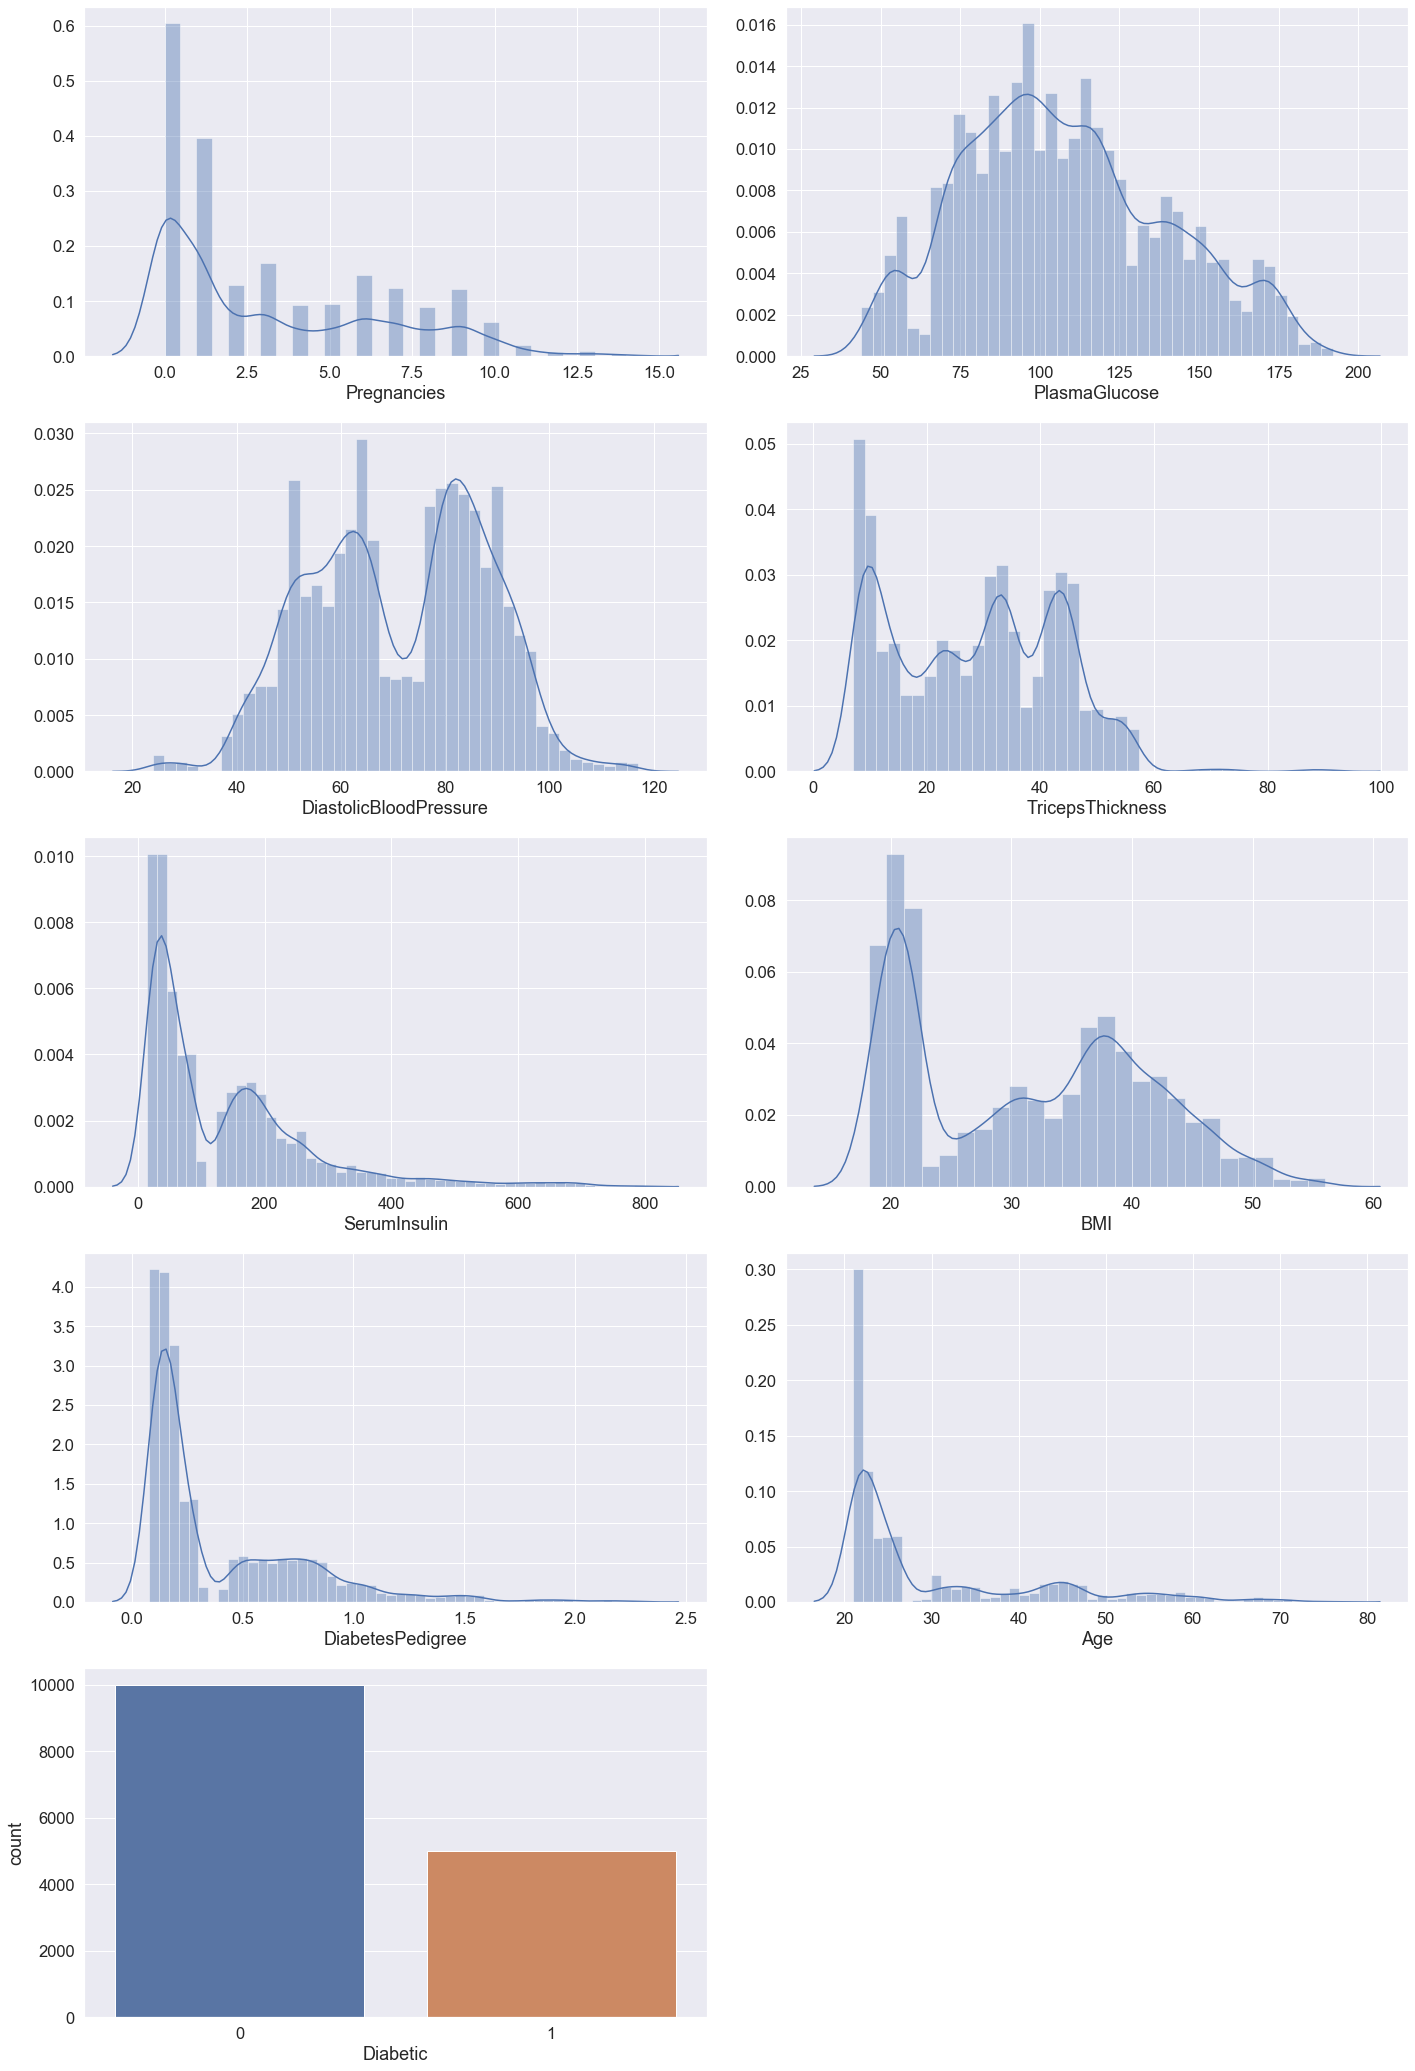

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.Pregnancies)
plt.subplot(7,2,2)
sns.distplot(df.PlasmaGlucose)
plt.subplot(7,2,3)
sns.distplot(df.DiastolicBloodPressure)
plt.subplot(7,2,4)
sns.distplot(df.TricepsThickness)
plt.subplot(7,2,5)
sns.distplot(df.SerumInsulin)
plt.subplot(7,2,6)
sns.distplot(df.BMI)
plt.subplot(7,2,7)
sns.distplot(df.DiabetesPedigree)
plt.subplot(7,2,8)
sns.distplot(df.Age)
plt.subplot(7,2,9)
sns.countplot(df.Diabetic)
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [9]:
df.columns

Index(['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age',
       'Diabetic'],
      dtype='object')

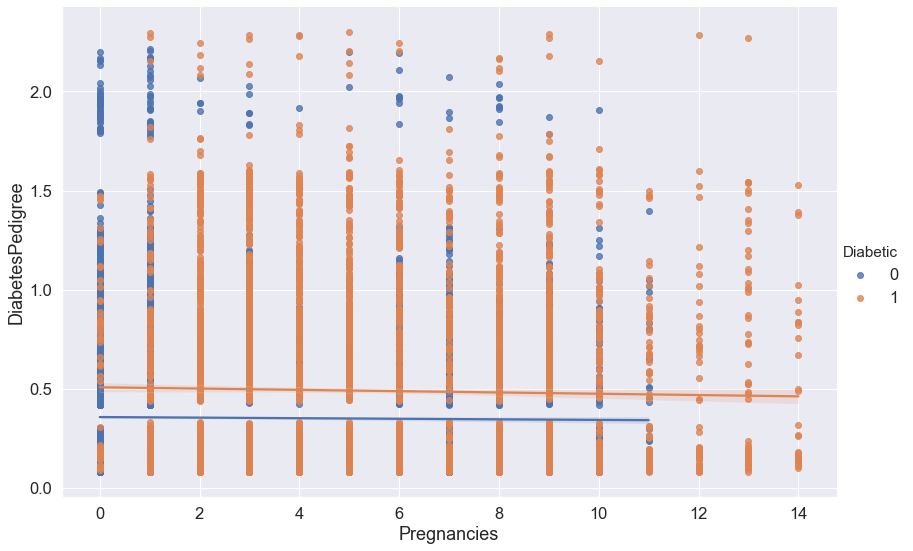

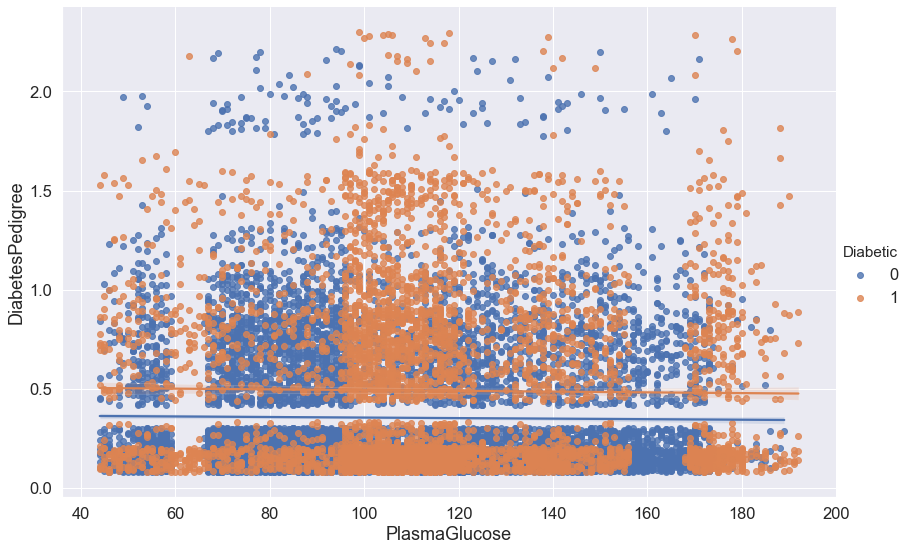

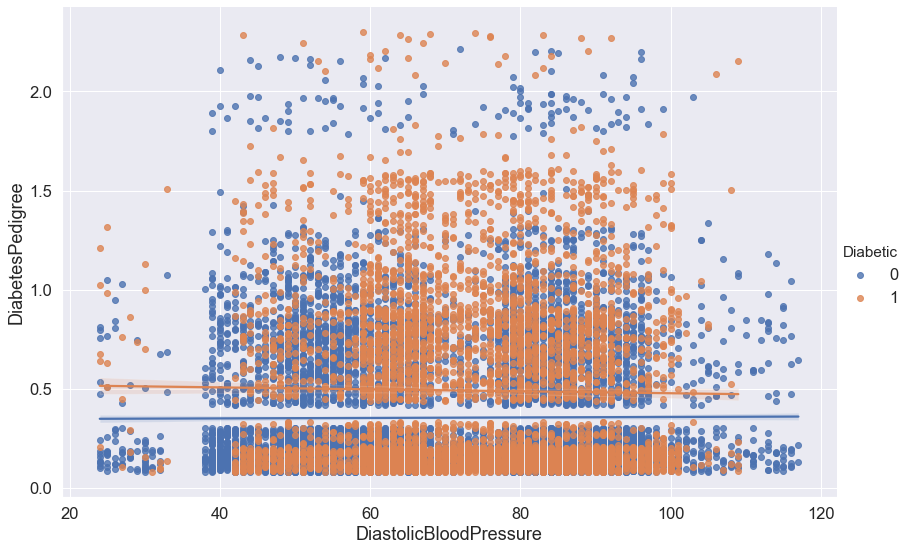

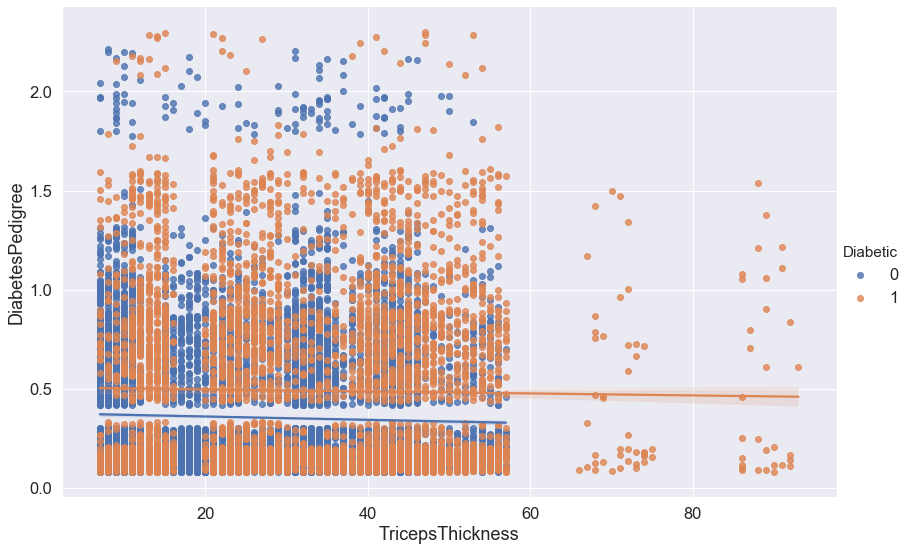

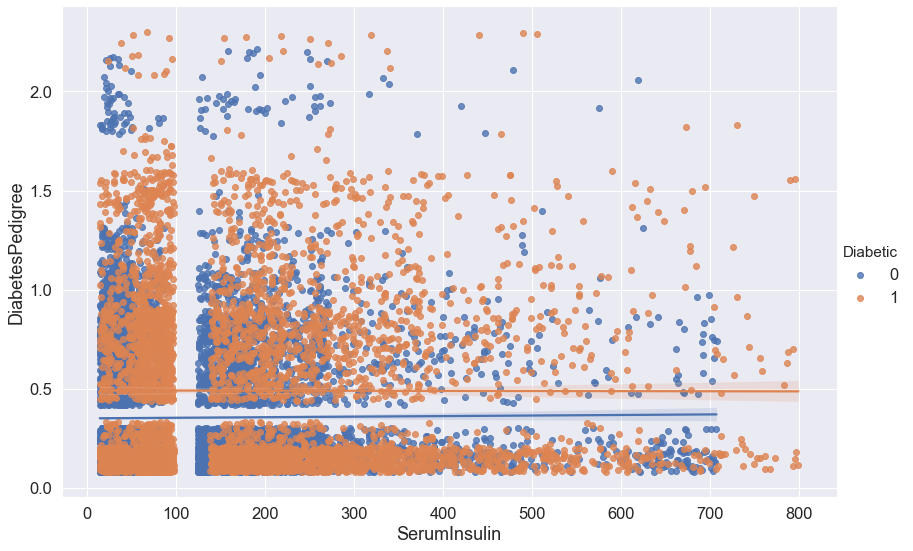

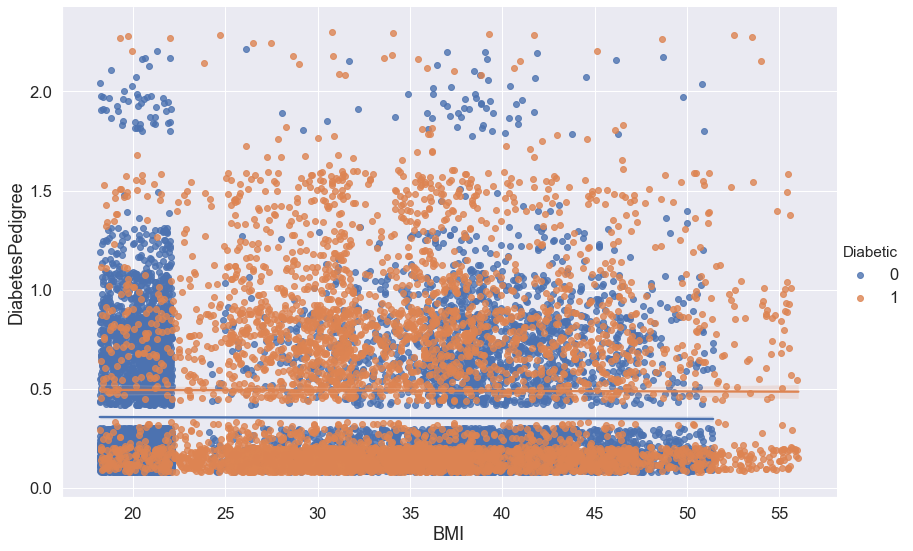

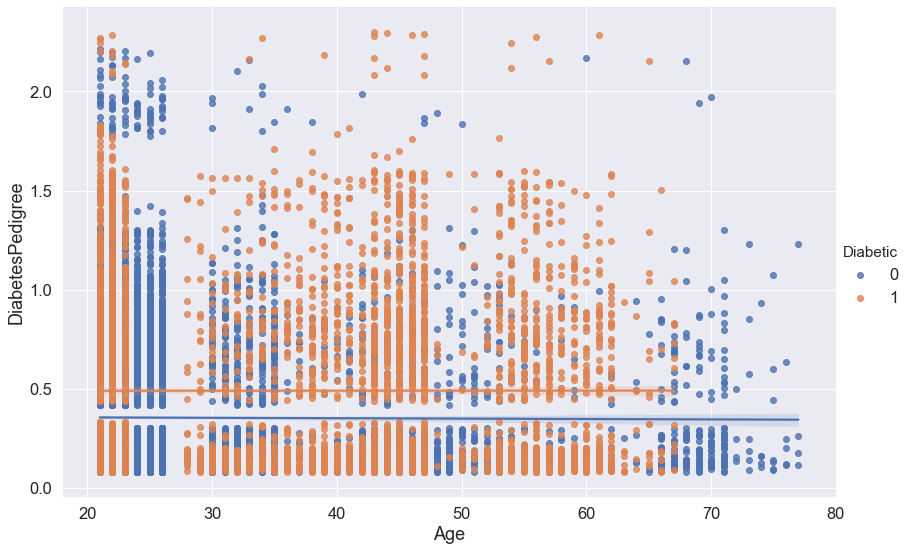

In [10]:
sns.lmplot(x='Pregnancies',y='DiabetesPedigree',data=df, hue='Diabetic', height=8, aspect=1.5)

sns.lmplot(x='PlasmaGlucose',y='DiabetesPedigree',data=df, hue='Diabetic', height=8, aspect=1.5)

sns.lmplot(x='DiastolicBloodPressure',y='DiabetesPedigree',data=df, hue='Diabetic', height=8, aspect=1.5)

sns.lmplot(x='TricepsThickness',y='DiabetesPedigree',data=df, hue='Diabetic', height=8, aspect=1.5)

sns.lmplot(x='SerumInsulin',y='DiabetesPedigree',data=df, hue='Diabetic', height=8, aspect=1.5)

sns.lmplot(x='BMI',y='DiabetesPedigree',data=df, hue='Diabetic', height=8, aspect=1.5)

sns.lmplot(x='Age',y='DiabetesPedigree',data=df, hue='Diabetic', height=8, aspect=1.5)


plt.show()

In [11]:
df.corr()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
PatientID,1.000000,0.006774,-0.001858,0.008746,-0.002406,-0.020698,-0.003156,-0.015413,-0.007096,-0.012494
Pregnancies,0.006774,1.000000,0.054502,0.043528,0.063605,0.104487,0.086386,0.054240,0.136972,0.407315
PlasmaGlucose,-0.001858,0.054502,1.000000,0.007212,0.027100,0.033545,0.020653,0.009057,0.038864,0.128004
DiastolicBloodPressure,0.008746,0.043528,0.007212,1.000000,0.011106,0.022649,0.015873,0.014099,0.041333,0.091307
TricepsThickness,-0.002406,0.063605,0.027100,0.011106,1.000000,0.029688,0.024745,-0.000951,0.061383,0.152505
SerumInsulin,-0.020698,0.104487,0.033545,0.022649,0.029688,1.000000,0.051223,0.046324,0.088007,0.247375
BMI,-0.003156,0.086386,0.020653,0.015873,0.024745,0.051223,1.000000,0.028868,0.062910,0.210508
DiabetesPedigree,-0.015413,0.054240,0.009057,0.014099,-0.000951,0.046324,0.028868,1.000000,0.055633,0.170302
Age,-0.007096,0.136972,0.038864,0.041333,0.061383,0.088007,0.062910,0.055633,1.000000,0.342605
Diabetic,-0.012494,0.407315,0.128004,0.091307,0.152505,0.247375,0.210508,0.170302,0.342605,1.000000


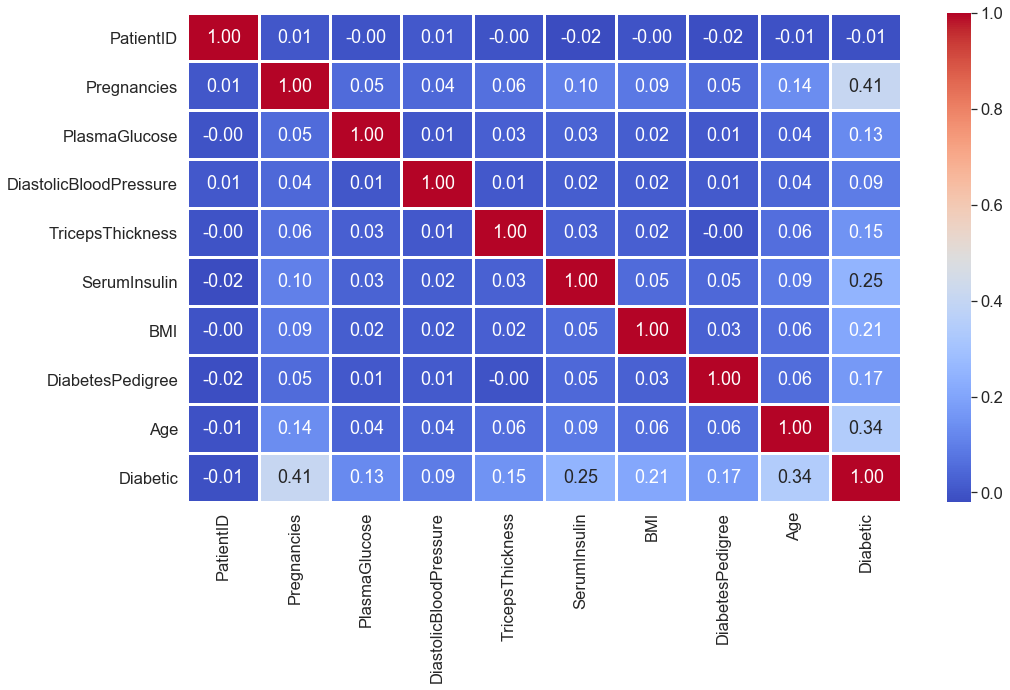

In [12]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

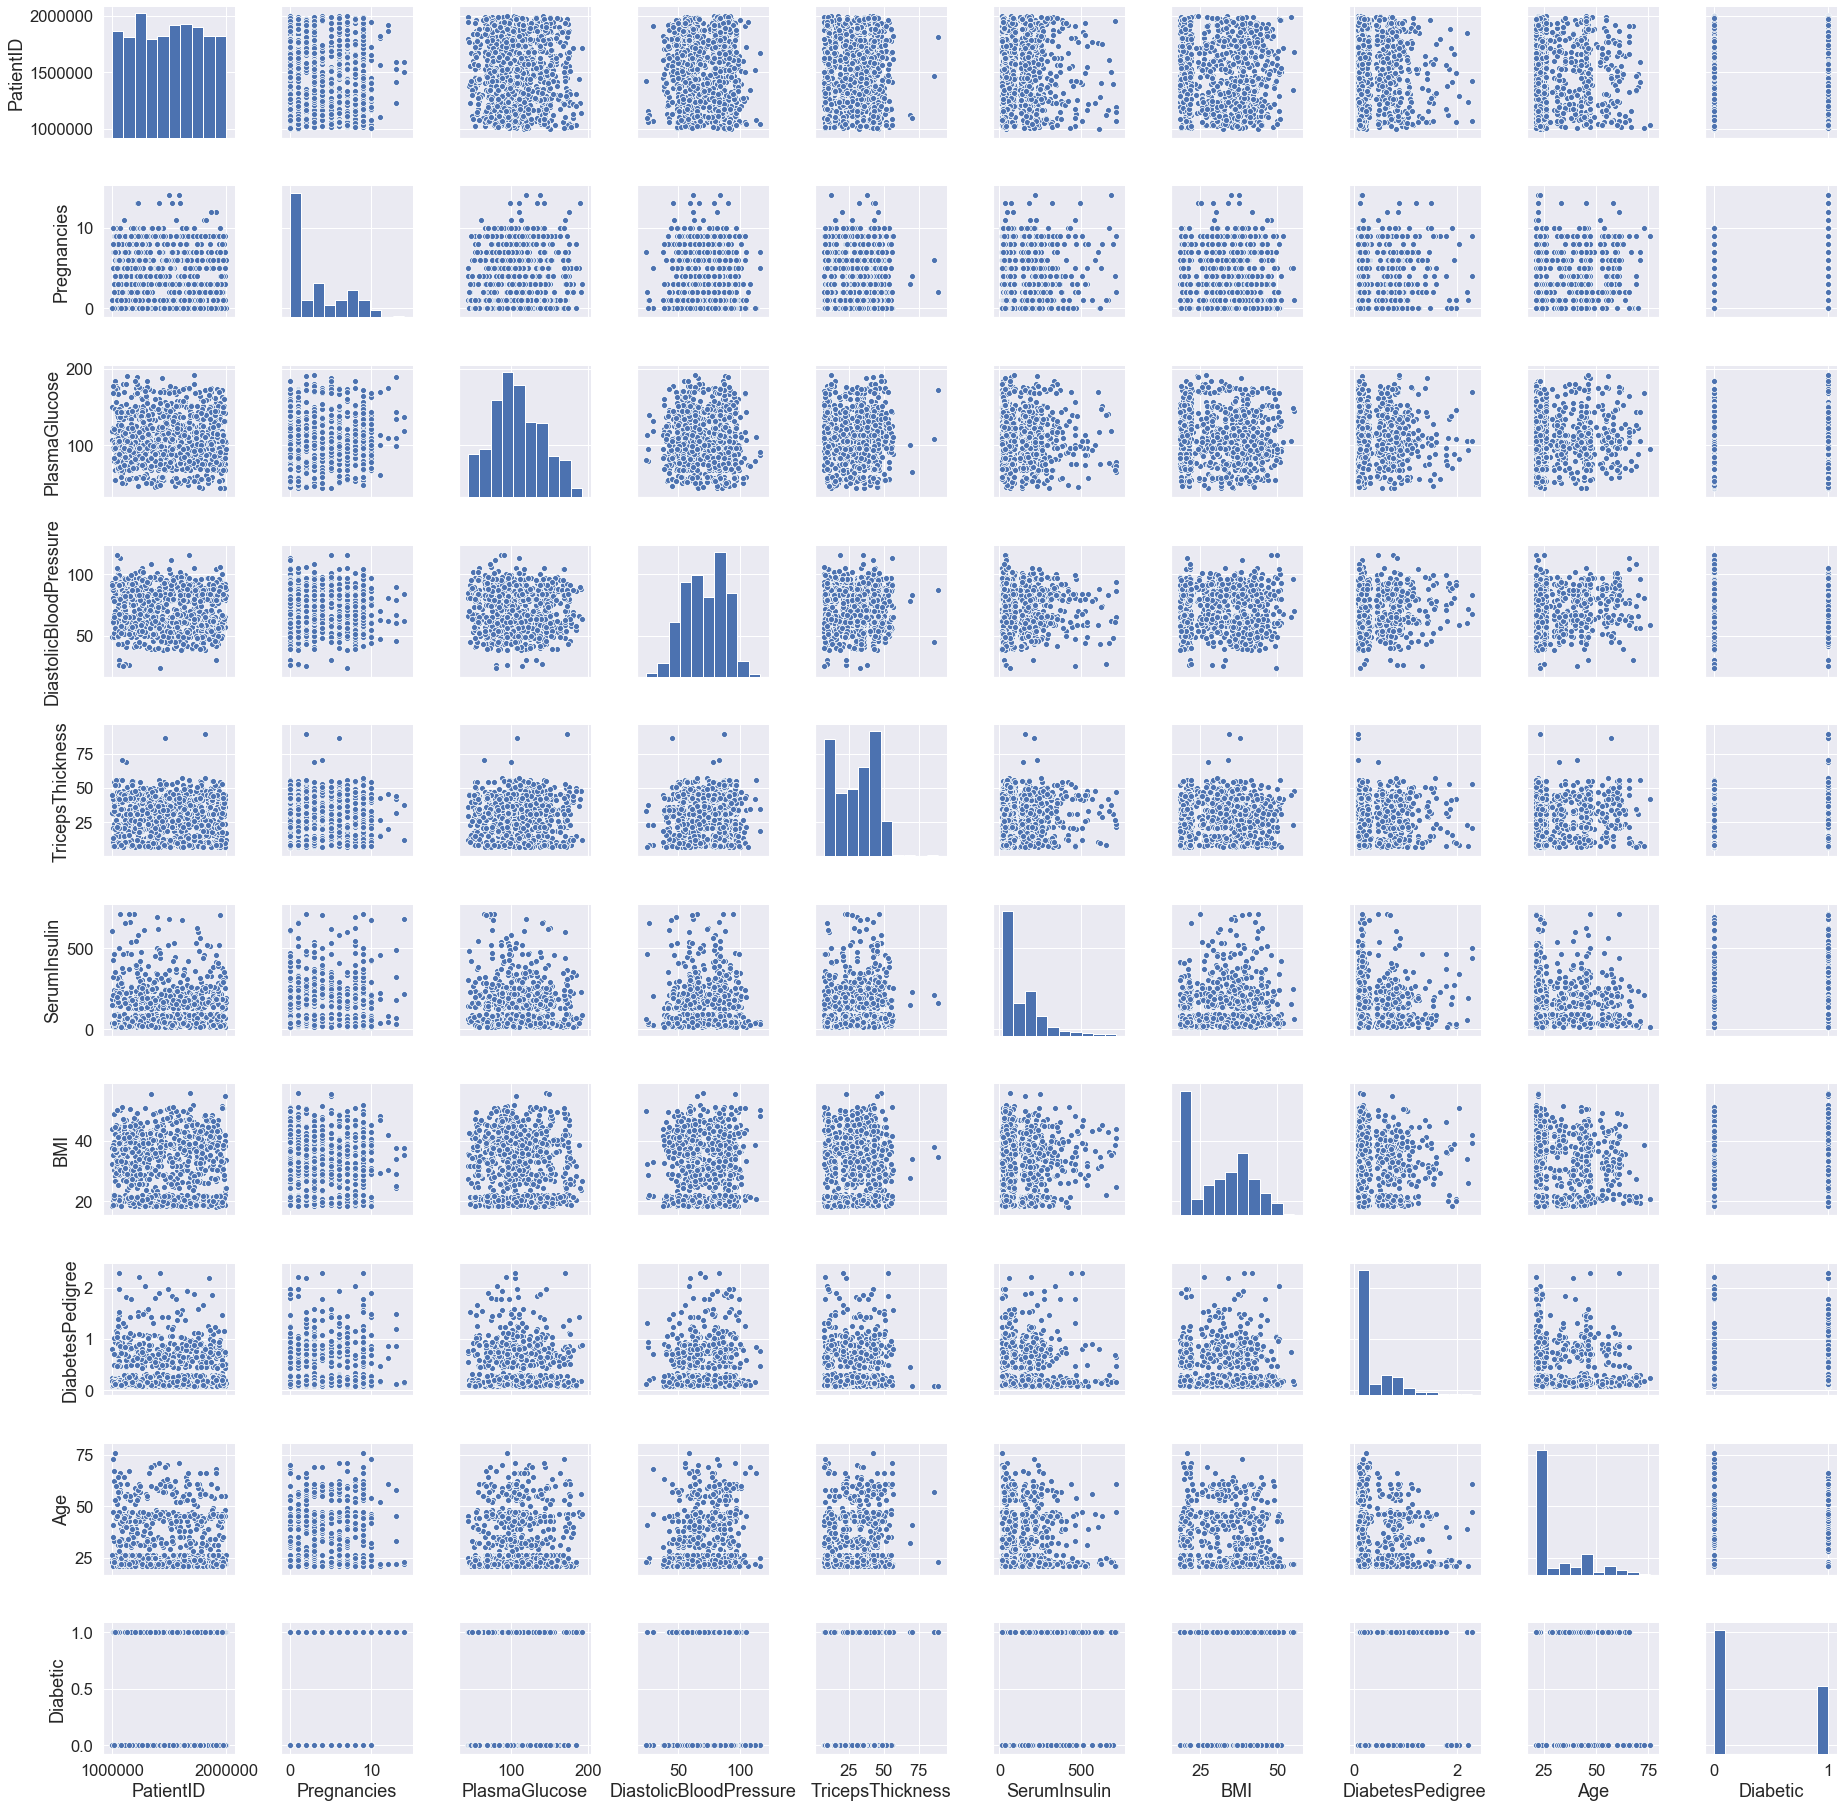

In [13]:
sns.pairplot(df.sample(1000))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [14]:
df.isnull().sum()

PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64

### Treat Duplicate Values

In [15]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [16]:
df.columns

Index(['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age',
       'Diabetic'],
      dtype='object')

In [17]:
df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


In [18]:
windsorizer = Winsorizer(distribution='skewed',tail='both',fold=1.5,
                         variables=['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age',])

In [19]:
windsorizer.fit(df)

Winsorizer(distribution='skewed', fold=1.5, tail='both',
           variables=['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
                      'TricepsThickness', 'SerumInsulin', 'BMI',
                      'DiabetesPedigree', 'Age'])

In [20]:
df2 = windsorizer.transform(df)

In [21]:
df2

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0.0,171.0,80.0,34.0,23.0,43.509726,1.213191,21.0,0
1,1147438,8.0,92.0,93.0,47.0,36.0,21.240576,0.158365,23.0,0
2,1640031,7.0,115.0,47.0,52.0,35.0,41.511523,0.079019,23.0,0
3,1883350,9.0,103.0,78.0,25.0,304.0,29.582192,1.282870,43.0,1
4,1424119,1.0,85.0,59.0,27.0,35.0,42.604536,0.549542,22.0,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10.0,65.0,60.0,46.0,177.0,33.512468,0.148327,41.0,1
14996,1744410,2.0,73.0,66.0,27.0,168.0,30.132636,0.862252,38.0,1
14997,1742742,0.0,93.0,89.0,43.0,57.0,18.690683,0.427049,24.0,0
14998,1099353,0.0,132.0,98.0,18.0,161.0,19.791645,0.302257,23.0,0


In [22]:
df2.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.795867,132.033800,31.509646,0.389139,29.693033,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.485958,114.552048,9.759000,0.345238,10.926697,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,80.000000,429.000000,56.034628,1.334098,54.500000,1.000000


In [23]:
windsorizer.left_tail_caps_

{'Pregnancies': -9.0,
 'PlasmaGlucose': 16.5,
 'DiastolicBloodPressure': 17.5,
 'TricepsThickness': -24.0,
 'SerumInsulin': -195.0,
 'BMI': -5.7398189600000045,
 'DiabetesPedigree': -0.580069375625,
 'Age': 2.5}

In [24]:
windsorizer.right_tail_caps_

{'Pregnancies': 15.0,
 'PlasmaGlucose': 196.5,
 'DiastolicBloodPressure': 125.5,
 'TricepsThickness': 80.0,
 'SerumInsulin': 429.0,
 'BMI': 66.25939826000001,
 'DiabetesPedigree': 1.334097815375,
 'Age': 54.5}

### Treat Data Types

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  float64
 2   PlasmaGlucose           15000 non-null  float64
 3   DiastolicBloodPressure  15000 non-null  float64
 4   TricepsThickness        15000 non-null  float64
 5   SerumInsulin            15000 non-null  float64
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  float64
 9   Diabetic                15000 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 1.1 MB


### Combine with doctors data

In [26]:
df3 = pd.read_csv("doctors.csv",encoding='ISO-8859-1')

In [27]:
df3

,PatientID,Physician
0,1000038,Jeanne Vestergaard
1,1000069,Sheldon Comeaux
2,1000118,Brain Dulaney
3,1000183,Alaine Poisson
4,1000326,Erik Collado
...,...,...
14890,1999765,Rosie Reeves
14891,1999836,Carlene O'Neill
14892,1999864,Arnold Valenti
14893,1999940,Daitaro Ishida


In [28]:
df4 = pd.merge(left=df2, right=df3, how='left', left_on='PatientID', right_on='PatientID')

In [29]:
df4

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician
0,1354778,0.0,171.0,80.0,34.0,23.0,43.509726,1.213191,21.0,0,Dan Drayton
1,1147438,8.0,92.0,93.0,47.0,36.0,21.240576,0.158365,23.0,0,Anthony Frizzell
2,1640031,7.0,115.0,47.0,52.0,35.0,41.511523,0.079019,23.0,0,Gordon Fredrickson
3,1883350,9.0,103.0,78.0,25.0,304.0,29.582192,1.282870,43.0,1,Chad Corbitt
4,1424119,1.0,85.0,59.0,27.0,35.0,42.604536,0.549542,22.0,0,Zachary Fellows
...,...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10.0,65.0,60.0,46.0,177.0,33.512468,0.148327,41.0,1,Letha Walls
14996,1744410,2.0,73.0,66.0,27.0,168.0,30.132636,0.862252,38.0,1,Janna Gamble
14997,1742742,0.0,93.0,89.0,43.0,57.0,18.690683,0.427049,24.0,0,Aisha Witt
14998,1099353,0.0,132.0,98.0,18.0,161.0,19.791645,0.302257,23.0,0,Carey Merrill


### Drop unwanted features

In [30]:
df4.columns

Index(['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age',
       'Diabetic', 'Physician'],
      dtype='object')

In [31]:
df4.drop(['PatientID','Physician'],axis=1,inplace=True)

In [32]:
df4

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,0.0,171.0,80.0,34.0,23.0,43.509726,1.213191,21.0,0
1,8.0,92.0,93.0,47.0,36.0,21.240576,0.158365,23.0,0
2,7.0,115.0,47.0,52.0,35.0,41.511523,0.079019,23.0,0
3,9.0,103.0,78.0,25.0,304.0,29.582192,1.282870,43.0,1
4,1.0,85.0,59.0,27.0,35.0,42.604536,0.549542,22.0,0
...,...,...,...,...,...,...,...,...,...
14995,10.0,65.0,60.0,46.0,177.0,33.512468,0.148327,41.0,1
14996,2.0,73.0,66.0,27.0,168.0,30.132636,0.862252,38.0,1
14997,0.0,93.0,89.0,43.0,57.0,18.690683,0.427049,24.0,0
14998,0.0,132.0,98.0,18.0,161.0,19.791645,0.302257,23.0,0


### Create and save processed dataset

In [33]:
#df4.to_csv("diabetestrain.csv",index=False)

In [34]:
df4.shape

(15000, 9)

### Train Test Split

In [35]:
X = df4.iloc[:,0:8]
y = df4.iloc[:,8]

### Treat Imbalance Data

In [36]:
y.value_counts()

0    10000
1     5000
Name: Diabetic, dtype: int64

In [37]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [38]:
new_X, new_y = ros.fit_resample(X, y)

In [39]:
new_y.value_counts()

1    10000
0    10000
Name: Diabetic, dtype: int64

In [40]:
new_X

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age
0,0.0,171.0,80.0,34.0,23.0,43.509726,1.213191,21.0
1,8.0,92.0,93.0,47.0,36.0,21.240576,0.158365,23.0
2,7.0,115.0,47.0,52.0,35.0,41.511523,0.079019,23.0
3,9.0,103.0,78.0,25.0,304.0,29.582192,1.282870,43.0
4,1.0,85.0,59.0,27.0,35.0,42.604536,0.549542,22.0
...,...,...,...,...,...,...,...,...
19995,1.0,114.0,101.0,49.0,222.0,38.827057,0.122315,44.0
19996,4.0,119.0,61.0,80.0,69.0,23.378864,1.078566,45.0
19997,3.0,105.0,69.0,31.0,429.0,38.484043,0.088112,22.0
19998,2.0,101.0,79.0,39.0,173.0,36.338242,0.200478,40.0


In [41]:
new_X.values, new_y.values

(array([[0.00000000e+00, 1.71000000e+02, 8.00000000e+01, ...,
         4.35097259e+01, 1.21319135e+00, 2.10000000e+01],
        [8.00000000e+00, 9.20000000e+01, 9.30000000e+01, ...,
         2.12405757e+01, 1.58364981e-01, 2.30000000e+01],
        [7.00000000e+00, 1.15000000e+02, 4.70000000e+01, ...,
         4.15115235e+01, 7.90185680e-02, 2.30000000e+01],
        ...,
        [3.00000000e+00, 1.05000000e+02, 6.90000000e+01, ...,
         3.84840429e+01, 8.81120680e-02, 2.20000000e+01],
        [2.00000000e+00, 1.01000000e+02, 7.90000000e+01, ...,
         3.63382419e+01, 2.00478055e-01, 4.00000000e+01],
        [5.00000000e+00, 1.08000000e+02, 9.00000000e+01, ...,
         3.89493190e+01, 8.48050240e-02, 5.45000000e+01]]),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16000, 8), (4000, 8), (16000,), (4000,))

### Feature Scaling

In [44]:
X_train

array([[2.00000000e+00, 1.72000000e+02, 7.00000000e+01, ...,
        5.07801900e+01, 8.10216330e-02, 4.60000000e+01],
       [9.00000000e+00, 1.36000000e+02, 8.20000000e+01, ...,
        3.96031536e+01, 8.03044581e-01, 2.10000000e+01],
       [2.00000000e+00, 8.00000000e+01, 6.30000000e+01, ...,
        2.11759441e+01, 1.57879159e-01, 2.30000000e+01],
       ...,
       [1.00000000e+00, 6.50000000e+01, 6.20000000e+01, ...,
        2.17633987e+01, 8.64349166e-01, 4.60000000e+01],
       [4.00000000e+00, 1.80000000e+02, 7.60000000e+01, ...,
        5.16793303e+01, 8.79731380e-02, 5.45000000e+01],
       [3.00000000e+00, 1.63000000e+02, 3.90000000e+01, ...,
        3.58990159e+01, 1.33409782e+00, 4.80000000e+01]])

In [45]:
scaler = StandardScaler()

In [46]:
X_train_scaled = scaler.fit_transform(X_train)

In [47]:
X_test_scaled = scaler.transform(X_test)

In [48]:
X_train_scaled

array([[-0.50494507,  1.97057315, -0.10321185, ...,  1.94977844,
        -0.9040646 ,  1.28289021],
       [ 1.54054999,  0.83919096,  0.63712794, ...,  0.77580693,
         1.09065035, -0.8588118 ],
       [-0.50494507, -0.9207369 , -0.53507672, ..., -1.15968096,
        -0.69173221, -0.68747564],
       ...,
       [-0.79715865, -1.39214615, -0.59677171, ..., -1.09797812,
         1.26001501,  1.28289021],
       [ 0.07948209,  2.22199142,  0.26695804, ...,  2.04421895,
        -0.88485985,  2.01106889],
       [-0.21273149,  1.6877276 , -2.0157563 , ...,  0.38674566,
         2.55777799,  1.45422637]])

In [49]:
X_test_scaled

array([[-0.79715865,  1.15346379, -0.34999178, ...,  0.46130169,
         0.09299107,  2.01106889],
       [-1.08937223,  0.90204552, -0.84355164, ..., -1.45468989,
        -0.90283054, -0.8588118 ],
       [-1.08937223, -0.63789135,  0.57543295, ...,  1.68778657,
        -0.81429616,  1.02588597],
       ...,
       [-1.08937223, -1.70641898, -1.6455864 , ..., -1.09458507,
         1.15731829,  0.68321365],
       [-1.08937223, -1.32929158,  1.25407776, ..., -1.18731775,
        -0.77765055, -0.68747564],
       [ 0.07948209,  0.43063628, -0.72016167, ..., -1.35859139,
        -0.5816859 , -0.8588118 ]])

### Model Training

### Using XGBoost (Scikit-Learn)

In [50]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=200, objective='binary:logistic')

In [51]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.127
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.12725
[2]	validation_0-error:0.12275
[3]	validation_0-error:0.12675
[4]	validation_0-error:0.12475
[5]	validation_0-error:0.12475
[6]	validation_0-error:0.1255
[7]	validation_0-error:0.12525
[8]	validation_0-error:0.1165
[9]	validation_0-error:0.11475
[10]	validation_0-error:0.1045
[11]	validation_0-error:0.10975
[12]	validation_0-error:0.10925
[13]	validation_0-error:0.11225
[14]	validation_0-error:0.10625
[15]	validation_0-error:0.10225
[16]	validation_0-error:0.101
[17]	validation_0-error:0.09375
[18]	validation_0-error:0.09125
[19]	validation_0-error:0.092
[20]	validation_0-error:0.08775
[21]	validation_0-error:0.08825
[22]	validation_0-error:0.085
[23]	validation_0-error:0.0825
[24]	validation_0-error:0.07975
[25]	validation_0-error:0.08075
[26]	validation_0-error:0.07925
[27]	validation_0-error:0.07975
[28]	validation_0-error:0.0785
[29]	validation_0-error:0.078

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [52]:
y_pred = xgbmodel.predict(X_test_scaled)

In [53]:
y_pred

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

### Model Evaluation

In [54]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[1875,   86],
       [  82, 1957]], dtype=int64)

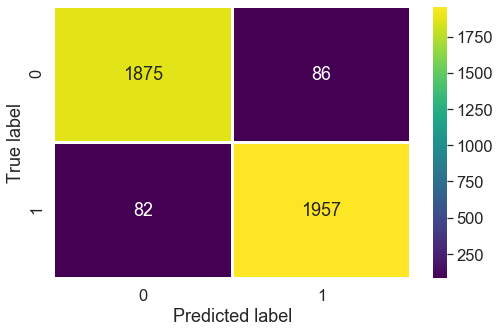

In [55]:
fig , ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

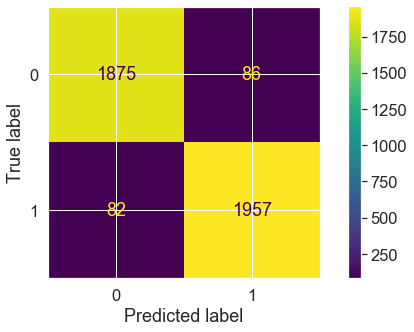

In [56]:
fig , ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(xgbmodel,X_test_scaled,y_test,values_format='.4g',ax=ax)
plt.show()

In [57]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1961
           1       0.96      0.96      0.96      2039

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



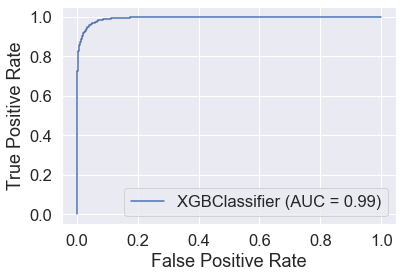

In [58]:
plot_roc_curve(xgbmodel,X_test_scaled,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [59]:
X.columns

Index(['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age'],
      dtype='object')

In [60]:
xgbmodel.get_booster().feature_names = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']

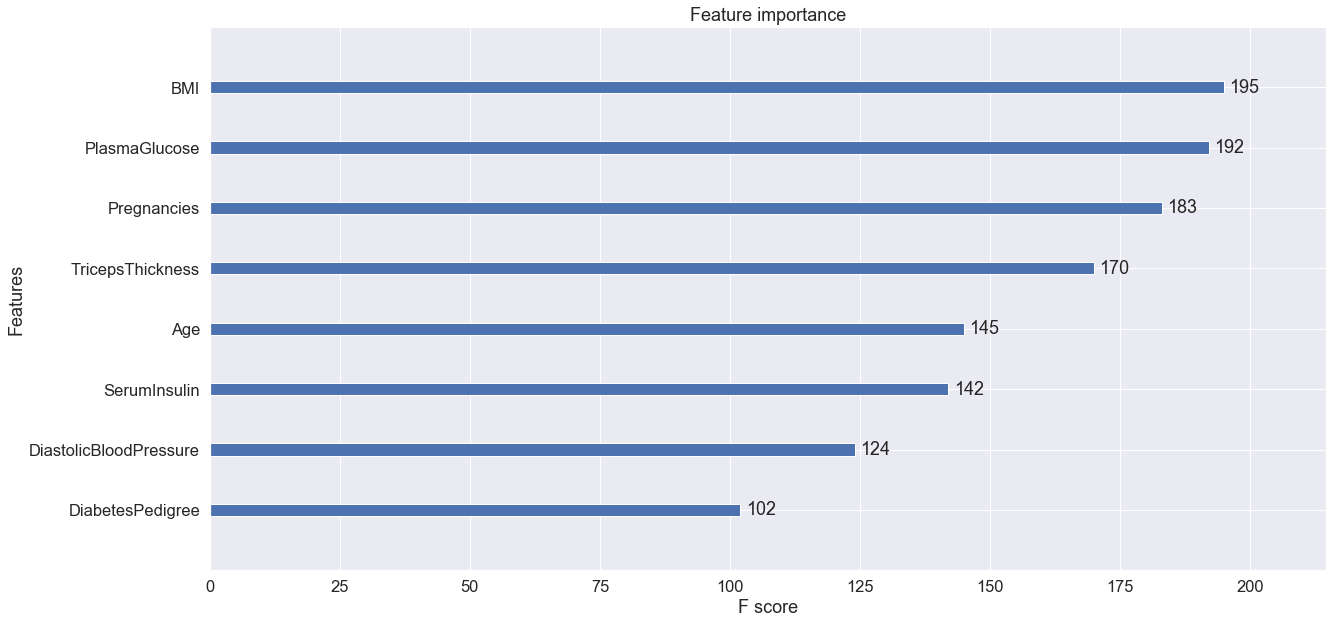

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

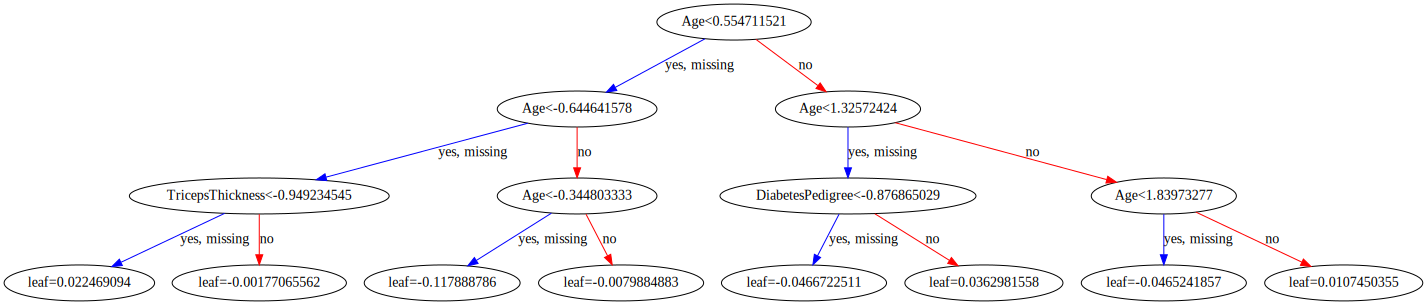

In [62]:
xgb.to_graphviz(xgbmodel,num_trees=180)

### Cross-Validation

In [63]:
cv = cross_val_score(xgbmodel,X_train_scaled,y_train,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.3s finished


In [64]:
cv.mean()

0.95525

### Model Tuning

### Save the Model

In [65]:
filename = 'modeldiabetes.sav'
dump(xgbmodel,open(filename,'wb'))